# 따릉이 대여량 예측 경진대회

이번 대회에서 주어진 데이터는 기상자료 개방포털의 단기예측 데이터와 예측일의 따릉이 대여 수 입니다.

쉽게말해 오늘 발표된 "내일의 날씨" 예보를 보고, 내일 사람들이 따릉이를 얼마나 대여할 지 예측하는 문제입니다.

자, 시작해 볼까요?

## 데이터 불러오기

우선 학습에 필요한 train데이터를 불러오겠습니다.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as xgb
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
bicycle = pd.read_csv('data/train.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [5]:
bicycle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


0   date_time                  시간  
1   wind_direction             풍향  
2   sky_condition              하늘 상태  
3   precipitation_form         강수량  
4   wind_speed                 풍속  
5   humidity                   습도  
6   low_temp                   최저 온도  
7   high_temp                  최고 온도  
8   Precipitation_Probability  강수량 가능성  
9   number_of_rentals          대여량  

지난번 데이콘 베이직 iris데이터는 학습에 알맞도록 잘 정제되어있는 데이터였는데요

이번 데이터는 기상자료 개방 포털의 자료와 서울 열린 데이터 광장에서 수집한 정제되지 않은 데이터입니다.

즉, 모든 데이터 셀이 채워져 있다고 가정할 수 없으며 때때로 '빈칸'이 존재할 수 있습니다.

빈칸이 있나 확인해보겠습니다!

## 일자 분리

모델에 수치를 넣고 학습시키기 위해선 글자나 문자를 숫자로 바꿔주는 작업이 필요합니다.

주어진 데이터를 살펴보면 date_time부분이 문자열(string)로 되어있는 것을 확인하실 수 있습니다.

이를 각각 년도, 월, 일로 나누어 숫자형으로 변환해 보겠습니다.

In [3]:
# 연월일 분리
bicycle['date_time'] = pd.to_datetime(bicycle['date_time'])

bicycle['year'] = bicycle['date_time'].dt.year
bicycle['month'] = bicycle['date_time'].dt.month
bicycle['day'] = bicycle['date_time'].dt.day
bicycle['weekday'] = bicycle['date_time'].dt.weekday

bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3


년도, 월, 일이 전부 잘 분리되어 들어간게 보이시나요?

이제 학습에 필요한 X와 y를 분리해 보겠습니다

## 변수 및 모델 정의

우리의 목적은 주어진 날씨 데이터(low_temp, high_temp, precipitaion, wind_speed, humidity, insolation, cloud, year, month, day)를 이용하여 사람들이 따릉이를 얼마나 빌리는지(number_of_rentals) 예측하는 것입니다.

그럼 날씨 데이터가 X, 따릉이 대여 수가 y가 되겠죠?

## 새로운 feature 생성

In [4]:
bicycle['temp'] = (bicycle['high_temp'] + bicycle['low_temp']) / 2
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday,temp
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6,16.800
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0,15.906
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1,12.814
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2,10.340
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3,8.148


In [10]:
bicycle.loc[:, ['humidity', 'number_of_rentals']]

,humidity,number_of_rentals
0,75.000,22994
1,69.833,28139
2,74.879,26817
3,71.849,26034
4,73.784,2833
...,...,...
268,78.378,96150
269,78.412,107001
270,72.736,98568
271,70.473,70053


In [11]:
bicycle[bicycle['humidity'] < 75]['number_of_rentals']

1       28139
2       26817
3       26034
4        2833
5       13297
        ...  
263     95453
264     98394
265    103214
270     98568
271     70053
Name: number_of_rentals, Length: 250, dtype: int64

In [12]:
bicycle[bicycle['humidity'] < 75]['number_of_rentals'].median()

64944.5

In [173]:
bicycle[bicycle['humidity'] >= 75]['number_of_rentals']

0       22994
22       1037
31       8374
35      19809
41       3551
45       7072
46       3802
47      19629
86       6391
87      41128
88      27757
90      26911
220      7600
227     64549
229     36761
230     55556
235     80357
237     68498
266     19756
267     46415
268     96150
269    107001
272     38086
Name: number_of_rentals, dtype: int64

In [174]:
bicycle[bicycle['humidity'] >= 75]['number_of_rentals'].median()

26911.0

In [18]:
bicycle.groupby(['weekday'])['number_of_rentals'].sum()

weekday
0    2330334
1    2288535
2    2347456
3    2324045
4    2372485
5    2374604
6    2226510
Name: number_of_rentals, dtype: int64

In [10]:
# 습도를 감정으로 
# 감정 = 100 / 습도
# 습도와 감정은 반비례, 습도가 올라가면 불쾌지수 업, 야외 외출 자제, 따릉이 대여수 감소
bicycle['feeling'] = (100 - bicycle['humidity']) / 100
# bicycle['feeling'] = (5/9)*bicycle['temp']-0.55*((100-bicycle['humidity'])/100)*((5/9)*bicycle['temp']-26)+32
bicycle['feeling']

0      0.25000
1      0.30167
2      0.25121
3      0.28151
4      0.26216
        ...   
268    0.21622
269    0.21588
270    0.27264
271    0.29527
272    0.22939
Name: feeling, Length: 273, dtype: float64

In [42]:
bicycle.loc[:, ['number_of_rentals', 'feeling', 'humidity', 'temp']]

,number_of_rentals,feeling,humidity,temp
0,22994,67.150148,75.000,16.8000
1,28139,62.523950,69.833,15.9060
2,26817,67.041812,74.879,12.8140
3,26034,64.328946,71.849,10.3400
4,2833,66.061420,73.784,8.1480
...,...,...,...,...
268,96150,70.174590,78.378,24.0130
269,107001,70.205032,78.412,24.8270
270,98568,65.123109,72.736,25.0265
271,70053,63.096965,70.473,22.8125


In [34]:
bicycle['month'].value_counts()
bicycle['year'].value_counts()
bicycle['day'].value_counts()

1     9
17    9
30    9
29    9
28    9
27    9
26    9
25    9
24    9
23    9
22    9
21    9
20    9
19    9
18    9
16    9
2     9
15    9
14    9
13    9
12    9
11    9
10    9
9     9
8     9
7     9
6     9
5     9
4     9
3     9
31    3
Name: day, dtype: int64

In [161]:
bicycle['humidity'].mean()

56.745490842490845

In [162]:
bicycle['humidity'].median()

55.845

In [163]:
bicycle['humidity'].min()

24.831

In [5]:
drop_features = ['date_time', 'wind_direction','precipitation_form', 'sky_condition']

In [19]:
# wind_speed, precipitation_probability 는 모델 성능에 영향을 주는 변수
train_x = bicycle.drop(drop_features + ['number_of_rentals'], axis=1)
train_y = bicycle[['number_of_rentals']]

In [10]:
X = bicycle.drop(drop_features + ['number_of_rentals'], axis=1)
y = bicycle.number_of_rentals

In [11]:
type(y)

pandas.core.series.Series

## 모델 학습

In [150]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # 모델 정의
model.fit(X, y) # 학습

LinearRegression()

굉장히 간단하게 학습이 끝났습니다.

모델이 실제로 데이터를 얼마나 잘 맞추는지 확인해볼까요?

In [70]:
# 랜덤포레스트

model = RandomForestRegressor(max_depth=3, random_state=0)
model.fit(X, y)



RandomForestRegressor(max_depth=3, random_state=0)

In [12]:
# XGBRegressor

model = xgb()
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [13]:
y_hat = model.predict(X) # y 예측

In [16]:
y

0       22994
1       28139
2       26817
3       26034
4        2833
        ...  
268     96150
269    107001
270     98568
271     70053
272     38086
Name: number_of_rentals, Length: 273, dtype: int64

In [17]:
y_hat

array([ 22997.676 ,  28139.906 ,  26817.68  ,  26029.73  ,   2833.588 ,
        13295.339 ,  13088.282 ,   7758.668 ,  23927.965 ,  20426.82  ,
        25551.16  ,  28875.814 ,  29495.818 ,   8223.887 ,  12712.416 ,
        29586.352 ,  28233.621 ,  23502.932 ,  20401.398 ,  28356.627 ,
        33145.137 ,   8094.2236,   1038.8545,  24557.668 ,  33729.973 ,
        32544.764 ,  32984.69  ,  33738.188 ,  35167.07  ,  32628.95  ,
        34589.15  ,   8377.142 ,  25961.523 ,  34062.633 ,  37380.062 ,
        19812.715 ,  40025.65  ,  33742.367 ,  37840.91  ,  36553.027 ,
        33921.88  ,   3548.4277,  35663.78  ,  35921.76  ,  36480.41  ,
         7071.688 ,   3802.7725,  19628.277 ,  43460.473 ,  39032.863 ,
        42019.92  ,  17453.812 ,  35978.19  ,  36855.113 ,  37590.33  ,
        37766.695 ,  39526.28  ,  40774.2   ,  29928.365 ,  39212.652 ,
        41615.65  ,  41969.75  ,  41675.47  ,  40566.418 ,  44014.98  ,
        44115.984 ,  40439.984 ,  42042.812 ,  46508.656 ,  3283

In [15]:
nmae = np.mean(abs(y_hat - y) / y) # nmae 계산

print(f'모델 NMAE: {nmae}')

모델 NMAE: 0.00010693111541750807


NMAE로 계산하여 0.32가 나왔습니다.

좋은 수치일까요 나쁜 수치일까요?

NMAE 0.32는 대략 예측치와 실제값이 32% 정도의 오차율을 보인다는 것을 의미합니다.

어떠신가요 여러분은 만족하시나요?

## 교차 검증 도입하기!

In [16]:
print(train_x.shape, train_y.shape)

(273, 9) (273, 1)


In [28]:
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

    print('-------------')
    print(X_train)
    print('-------------')
    print(X_val)
    print('-------------')
    print(y_train)
    print('-------------')
    print(y_val)

-------------
     wind_speed  humidity  low_temp  high_temp  Precipitation_Probability  \
1         3.278    69.833    12.812     19.000                     19.500   
3         3.138    71.849     8.312     12.368                     43.493   
5         3.734    68.885     2.500      9.895                     40.068   
7         3.865    53.243     4.312     14.211                     15.676   
9         5.607    54.054     8.375     18.474                     21.824   
..          ...       ...       ...        ...                        ...   
263       1.551    61.723    21.625     33.421                      2.027   
265       1.700    55.541    22.312     26.947                      8.176   
267       2.447    84.527    20.688     27.316                     54.054   
269       1.794    78.412    20.812     28.842                     21.081   
271       2.043    70.473    19.625     26.000                     15.541   

     year  month  day  weekday     temp  
1    2018      4   

In [21]:
# wind_speed, precipitation_probability 는 모델 성능에 영향을 주는 변수
train_x = bicycle.drop(drop_features + ['number_of_rentals'], axis=1)
train_y = bicycle[['number_of_rentals']]

In [22]:
train_x

,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday,temp
0,3.050,75.000,12.600,21.000,30.000,2018,4,1,6,16.8000
1,3.278,69.833,12.812,19.000,19.500,2018,4,2,0,15.9060
2,2.690,74.879,10.312,15.316,19.113,2018,4,3,1,12.8140
3,3.138,71.849,8.312,12.368,43.493,2018,4,4,2,10.3400
4,3.186,73.784,5.875,10.421,63.378,2018,4,5,3,8.1480
...,...,...,...,...,...,...,...,...,...,...
268,2.271,78.378,20.500,27.526,36.486,2020,6,26,4,24.0130
269,1.794,78.412,20.812,28.842,21.081,2020,6,27,5,24.8270
270,1.820,72.736,21.000,29.053,7.297,2020,6,28,6,25.0265
271,2.043,70.473,19.625,26.000,15.541,2020,6,29,0,22.8125


In [23]:
train_y

,number_of_rentals
0,22994
1,28139
2,26817
3,26034
4,2833
...,...
268,96150
269,107001
270,98568
271,70053


In [27]:
train_y['number_of_rentals'].shape

(273,)

In [26]:
print(train_y.shape)
print(y.shape)

(273, 1)
(273,)


In [24]:
y

0       22994
1       28139
2       26817
3       26034
4        2833
        ...  
268     96150
269    107001
270     98568
271     70053
272     38086
Name: number_of_rentals, Length: 273, dtype: int64

In [39]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical


folds=StratifiedKFold(n_splits=15, shuffle=True, random_state=55)
outcomes=[]

model2 = xgb()
# model.fit(X, y)
# X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
#                                                     stratify=train_y, test_size=0.25,
#                                                     random_state = 10086)
# sub=np.zeros((test_x.shape[0], 3))  
for train_index, val_index in folds.split(train_x, train_y):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    model2.fit(X_train, y_train)

    prediction = model2.predict(X_val)
    
    y = y_val.number_of_rentals
#     y = y_train['number_of_rentals']
    
    nmae = np.mean(abs(prediction - y) / y) # nmae 계산
#     print(prediction)
    print(f'모델 NMAE: {nmae}')
    
#     logloss=log_loss(to_categorical(y_val['number_of_rentals']), predictions)
#     outcomes.append(logloss)
#     print(f"FOLD {n_fold} : logloss:{logloss}")

#     sub+=clf.predict_proba(test_x)


# mean_outcome=np.mean(outcomes)
    
# print("Mean:{}".format(mean_outcome))
#     return sub/folds.n_splits

# my_submission = run_kfold(clf)

# y = y_val['number_of_rentals']
    
# nmae = np.mean(abs(predictions - y / y)) # nmae 계산

# print(f'모델 NMAE: {nmae}')

ValueError: n_splits=15 cannot be greater than the number of members in each class.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.5,
                                                    random_state = 10086)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [35]:
train_x

,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday
0,3.050,75.000,12.600,21.000,30.000,2018,4,1,6
1,3.278,69.833,12.812,19.000,19.500,2018,4,2,0
2,2.690,74.879,10.312,15.316,19.113,2018,4,3,1
3,3.138,71.849,8.312,12.368,43.493,2018,4,4,2
4,3.186,73.784,5.875,10.421,63.378,2018,4,5,3
...,...,...,...,...,...,...,...,...,...
268,2.271,78.378,20.500,27.526,36.486,2020,6,26,4
269,1.794,78.412,20.812,28.842,21.081,2020,6,27,5
270,1.820,72.736,21.000,29.053,7.297,2020,6,28,6
271,2.043,70.473,19.625,26.000,15.541,2020,6,29,0


In [36]:
train_y

,number_of_rentals
0,22994
1,28139
2,26817
3,26034
4,2833
...,...
268,96150
269,107001
270,98568
271,70053


In [37]:
model2 = xgb()
model2.fit(train_x, train_y)

pred = model2.predict(train_x)

y = y_train['number_of_rentals']
    
nmae = np.mean(abs(prediction - y / y)) # nmae 계산

print(f'모델 NMAE: {nmae}')


모델 NMAE: 60403.546867819394


## 상관관계 파악

In [121]:
bicycle_number = bicycle.select_dtypes(np.number)

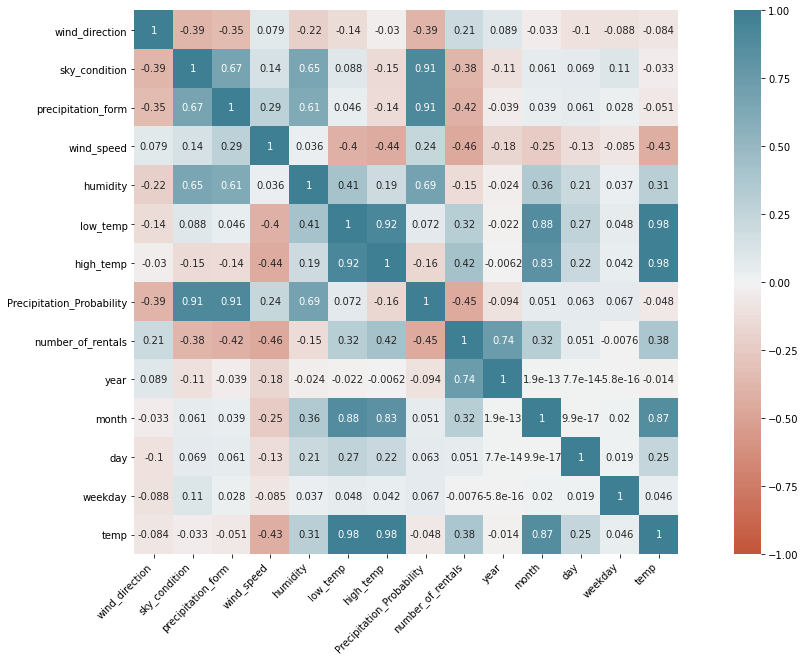

In [140]:
corr = bicycle_number.corr()

plt.figure(figsize=(20, 10))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True,
    annot = True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

## 예측값 눈으로 확인하기

0.32라는 숫자만 봐서는 모델이 어떤방식으로 맞췄는지 어디에서 오차가 더 많이 나는지 알 수 없습니다.

모델을 개선시키기 위해선 어느 포인트에서 예측을 하지 못했는지 모델의 약점을 알아야합니다.

그러기 위한 방법중 하나가 바로 오답노트인데요

여러분은 데이콘 제출페이지에 제출하는 방식으로 스코어를 확인할수도, train set의 정확도가 어느정도 나오는지 눈으로 확인할 수도 있습니다.

train set에서 오답노트를 확인하는것은 자칫 overfitting시킬 수 있어 조심해야하는 부분이지만 여러분에게 어느정도 인사이트를 줄 수도 있을겁니다.

그럼 plot을 그려서 확인해 보겠습니다.

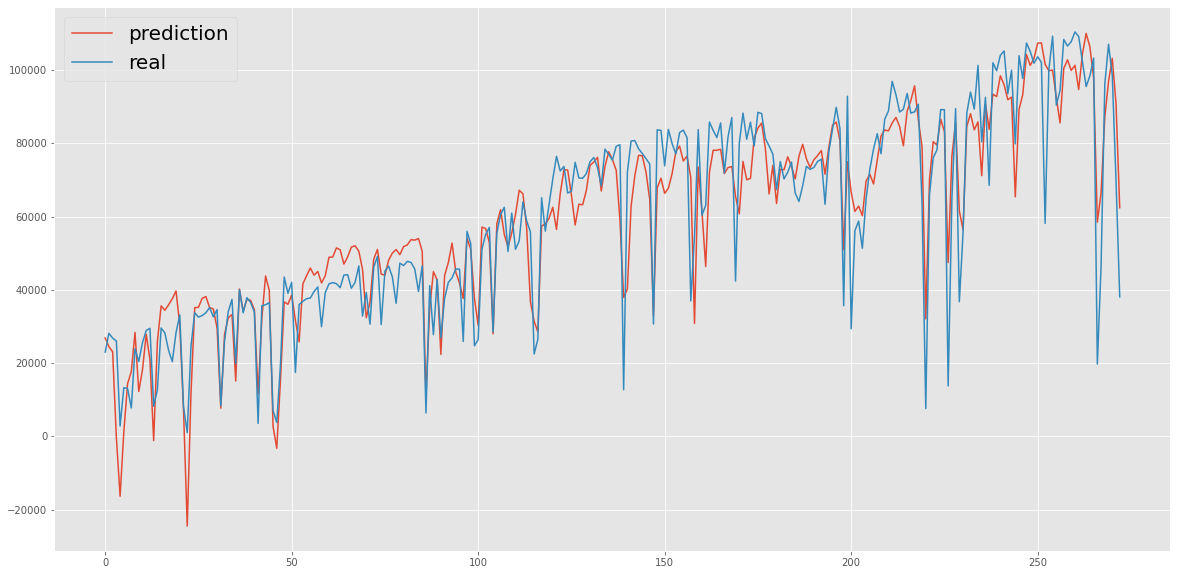

In [8]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label = 'prediction')
plt.plot(y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

파란선이 실제 따릉이 대여량, 붉은 선이 우리의 모델이 예측한 값입니다.

여러분이 보기에는 어떠신가요?

우리의 모델이 어느정도 예측을 하고 있는것같나요?

'추세는 따라가고 있는것 같다'정도는 이야기할 수 있을것 같습니다.

## 제출

이제 제출을 해보겠습니다.

주어진 test데이터로 예측을 진행한 다음 sample_submission.csv에 날짜별로 예측한 값을 넣어보겠습니다.

In [17]:
test = pd.read_csv('data/test.csv') # 데이터를 불러온 뒤
submission  = pd.read_csv('data/sample_submission.csv')

# check_missing_col(test) # 결측치 확인

test['date_time'] = pd.to_datetime(test['date_time'])

test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['day'] = test['date_time'].dt.day
test['weekday'] = test['date_time'].dt.weekday

test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,weekday
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,3
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,4
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,5
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,6
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,0


위에서 학습시킨 모델을 사용해서 예측을 진행합니다.

In [20]:
test['temp'] = (test['high_temp'] + test['low_temp']) / 2
test['feeling'] = (100 - test['humidity']) / 100

In [21]:
# 문자열인 date_time 컬럼 drop
test_X = test.drop(drop_features, axis = 1)

# train data로 학습시킨 모델에 test_X데이터를 넣고 예측
# test_yhat = model.predict(test_X)

test_yhat = model.predict(test_X)

In [22]:
# submission dataFrame 완성
submission['number_of_rentals'] = test_yhat

# 제출 파일 생성
submission.to_csv('submission2.csv', index= False)

이제 여러분의 제출 파일이 생성되었습니다.

결과물을 제출하고 여러분의 점수를 확인해보세요!